# 电子病历二次分析

*李沛尧*

---

### 主要内容

1. 如何进行探索性数据分析
2. 数据预处理的基本步骤
    - 丢失值
    - 离群值
3. 常用基本分析方法
    - 线性回归
    - 逻辑回归
    - 生存分析
4. 案例分析
    - 倾向性评分对比
    - 死亡率风险预测模型

## 1. 背景介绍

In [2]:
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
# 禁止所有warning
import warnings
warnings.filterwarnings('ignore')

读取数据文件：

In [4]:
df = pd.read_csv('../datasets/full_cohort_data.csv')

对数据的基本统计情况进行概览，可用`describe()`函数：

In [22]:
df.describe()

,aline_flg,icu_los_day,hospital_los_day,age,gender_num,weight_first,bmi,sapsi_first,sofa_first,service_num,...,platelet_first,sodium_first,potassium_first,tco2_first,chloride_first,bun_first,creatinine_first,po2_first,pco2_first,iv_day_1
count,1776.000000,1776.000000,1776.000000,1776.000000,1775.000000,1666.000000,1310.000000,1691.000000,1770.000000,1776.000000,...,1768.000000,1771.000000,1771.000000,1771.000000,1771.000000,1771.000000,1770.000000,1590.000000,1590.000000,1633.000000
mean,0.554054,3.346498,8.110923,54.379660,0.577465,80.075948,27.827316,14.136606,5.820904,0.552928,...,246.083145,139.559006,4.107623,24.416657,103.839074,19.277809,1.095706,227.623270,43.413836,1622.907946
std,0.497210,3.356261,8.157159,21.062854,0.494102,22.490516,8.210074,4.114302,2.334666,0.497331,...,99.865469,4.726209,0.794724,4.992172,5.734283,14.366890,1.083477,144.863403,13.980786,1677.129157
min,0.000000,0.500000,1.000000,15.180230,0.000000,30.000000,12.784877,3.000000,0.000000,0.000000,...,7.000000,105.000000,1.900000,2.000000,78.000000,2.000000,0.000000,22.000000,8.000000,0.000000
25%,0.000000,1.370000,3.000000,38.247318,0.000000,65.400000,22.617307,11.000000,4.000000,0.000000,...,182.000000,137.000000,3.600000,22.000000,101.000000,11.000000,0.700000,108.000000,36.000000,329.750000
50%,1.000000,2.185000,6.000000,53.678585,1.000000,77.000000,26.324846,14.000000,6.000000,1.000000,...,239.000000,140.000000,4.000000,24.000000,104.000000,15.000000,0.900000,195.000000,41.000000,1081.529175
75%,1.000000,4.002500,10.000000,72.762992,1.000000,90.000000,30.796551,17.000000,7.000000,1.000000,...,297.000000,142.000000,4.400000,27.000000,107.000000,22.000000,1.100000,323.000000,47.000000,2493.900146
max,1.000000,28.240000,112.000000,99.110950,1.000000,257.600000,98.797134,32.000000,17.000000,1.000000,...,988.000000,165.000000,9.800000,62.000000,133.000000,139.000000,18.300000,634.000000,158.000000,13910.000000


我们可以查看包含哪些基本信息

In [23]:
df.columns

Index(['aline_flg', 'icu_los_day', 'hospital_los_day', 'age', 'gender_num',
       'weight_first', 'bmi', 'sapsi_first', 'sofa_first', 'service_unit',
       'service_num', 'day_icu_intime', 'day_icu_intime_num',
       'hour_icu_intime', 'hosp_exp_flg', 'icu_exp_flg', 'day_28_flg',
       'mort_day_censored', 'censor_flg', 'sepsis_flg', 'chf_flg', 'afib_flg',
       'renal_flg', 'liver_flg', 'copd_flg', 'cad_flg', 'stroke_flg',
       'mal_flg', 'resp_flg', 'map_1st', 'hr_1st', 'temp_1st', 'spo2_1st',
       'abg_count', 'wbc_first', 'hgb_first', 'platelet_first', 'sodium_first',
       'potassium_first', 'tco2_first', 'chloride_first', 'bun_first',
       'creatinine_first', 'po2_first', 'pco2_first', 'iv_day_1'],
      dtype='object')

数据集中包含以下基本变量：

#### 暴露变量

- aline_flg（是否插入动脉置管）

#### 结局变量

- day_28_flg（28天死亡）
- icu_exp_flag（ICU死亡）
- hosp_exp_flag（住院死亡）

#### 协变量

- 人口统计学：age （年龄）、gender_num（性别）、weight_first（第一次体重记录）、bmi（BMI指数）
- 临床评分：sapsi_first（第一次SAPS评分）、sofa_first（第一次SOFA评分）

## 二、 探索性数据分析

探索性数据分析（Explotary Data Analysis, EDA）在数据分析中是至关重要的第一步，我们需要根据**数据类型**、**分析目的**选择合适的EDA方法。

常见的方法包括直方图、散点图、箱图等。

### 2.1 单变量

单变量常用的EDA方法包括柱状图等。

### 2.2 多变量

如果我们想查看要对多个变量相互之间的分布关系时，我们可以用seaborn中的`PairGrid`。

首先我们选择我们感兴趣的变量：

In [26]:
subset = df[['day_28_flg','bmi', 'wbc_first', 'hgb_first', 'platelet_first']]
subset.columns = ['day_28_flg', 'BMI', 'WBC', 'HGB', 'Platelet']

将变量`day_28_flg`变为Categorical类型:

In [27]:
from pandas.api.types import CategoricalDtype

subset['day_28_flg'] = subset.day_28_flg.astype('category').map({0:'Live', 1:'Death'})

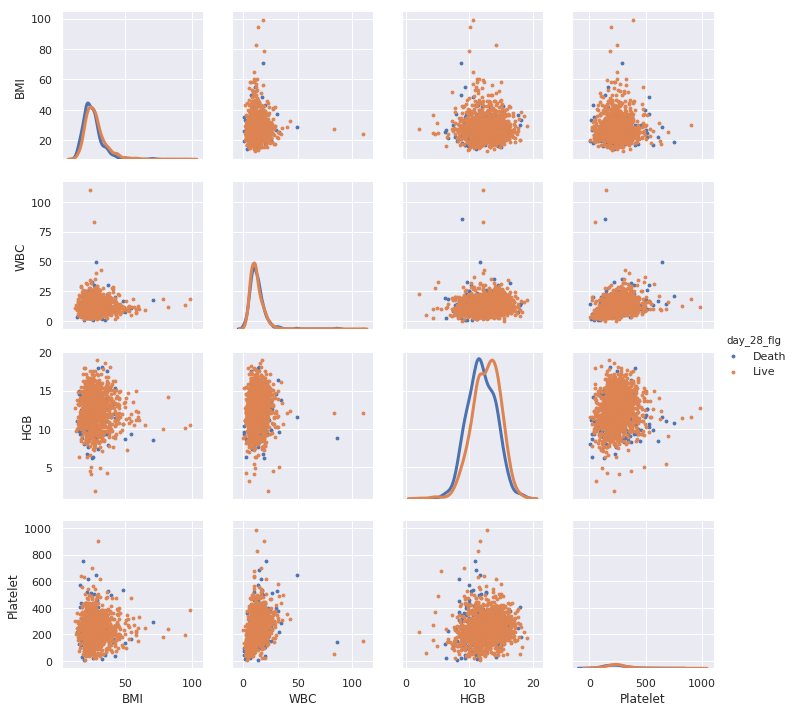

In [33]:
g = sns.PairGrid(subset, hue="day_28_flg")
g = g.map_diag(sns.kdeplot, lw=3, legend=False)
g = g.map_offdiag(plt.scatter, s=8)
g = g.add_legend()

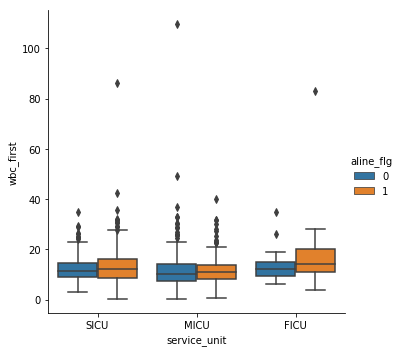

In [8]:
sns.catplot(x="service_unit", y="wbc_first", hue="aline_flg", kind="box", data=df);

#### 正态性检验（Normality Test）

##### 可视化：QQplot

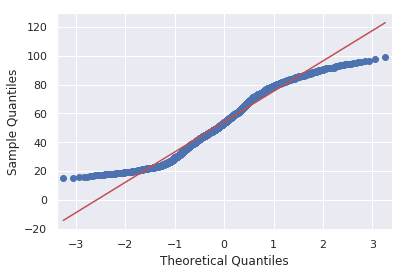

In [14]:
from statsmodels.graphics.gofplots import qqplot
qqplot(df.age, line='s');

##### Shapiro-Wilk 检验

In [15]:
from scipy.stats import shapiro

stat, p = shapiro(df.hgb_first.dropna().copy())
print("Statistics={:.3f} and p-value={:.3f}".format(stat, p));
alpha = 0.05
print("变量服从正太分布。") if p > alpha else print("变量不服从正太分布。")

Statistics=0.992 and p-value=0.000
变量不服从正太分布。


## 三、数据预处理

### 3.1 丢失值

#### 3.1.1 丢失值可视化

#### 3.1.2 丢失值产生机制及常用处理方法

#### 处理方法1：删除所有包含丢失值的记录

我们可以用`dropna()`函数直接删除包含缺失值的记录，这种方法通常适用于MCAR，但是使样本大大减少。

In [ ]:
bmi_df = df[['aline_flg', 'bmi', 'wbc_first']]
bmi_complete_df = bmi_df.dropna()

#### 处理方法2： 插补法

我们可以根据变量自身的统计分布进行插值，例如**中位数插值**、**平均数插值**；也可以根据变量之间的相关性建立缺失变量和其他变量之间的模型，然后基于模型进行插补，常用的方法包括多重插补。

##### 均值插补

In [18]:
missing_df = df.copy()
missing_df.fillna(missing_df.mean(), inplace=True)

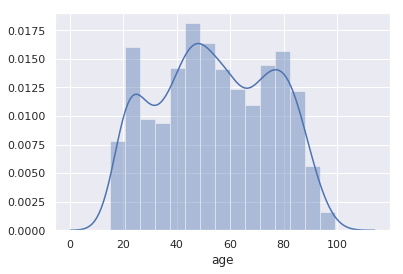

In [25]:
sns.distplot(missing_df.age);

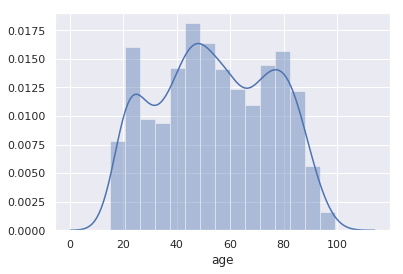

In [26]:
sns.distplot(df.age.dropna());

##### k近邻插补

###### 多重插补

#### 3.1.3 插补效果评估

### 离群值

进行离群值分析前，通常来说我们需要用 **箱须图（Box-whiske plot)** 对每一个连续型变量进行可视化分析。
例如我们对常见的几个生理生化指标进行箱盒图分析：

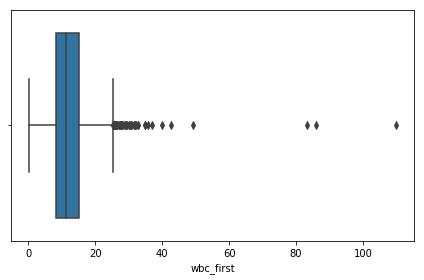

In [10]:
box_vars = ['wbc_first', 'hgb_first', 'platelet_first', 'sodium_first',
            'potassium_first', 'chloride_first', 'bun_first', 'creatinine_first']

sns.boxplot(df['wbc_first'])

plt.tight_layout()

常用的离群值检测及处理办法可以是基于 **统计分布** 或者基于 **聚类** 的方法。

#### 统计分布

统计方法包括**Tukey**方法，和**z-score**方法：

- Tukey方法通过**分布的分位数**确定outliers的范围
- z-score则是通过**均值和方差**确定outliers范围。

In [56]:
def remove_outliers(df, cols, method='tukey', verbose=False):
    """
    通过以下不同的统计方法删除:
    
    - Tukey's method
    - z-score
    
    :param df: 数据列
    :param cols: 需要删除离群值的列名
    :param method: 具体的方法, 'tukey'或者'zscore', 默认为'tukey'
    :param verbose: 是否打印具体过程，默认为False
    :type df: pandas.Series
    :type cols: list
    :type method: str
    :type verbose: bool
    """
    if verbose:
        print("开始删除离群值，方法为：{}".format(method))
    for col in cols:
        if method == 'tukey':
            Q1 = df[col].describe()['25%']
            Q3 = df[col].describe()['75%']
            IQR = Q3 - Q1
            upper_bound = Q3 + 1.5 * IQR
            lower_bound = Q1 - 1.5 * IQR
            if verbose:
                print("For column {}: Q1 is {:.2f}, Q3 is {:.2f}".format(col, Q1, Q3)) 
            df[(df[col] >= lower_bound) & (df[col] <= upper_bound)] = 
        if method == 'zscore':
            z_score = (df - df.mean()) / df.std() 
            return df[z_score.abs() <= 3]
    return df

In [57]:
remove_outliers(df, ['wbc_first', 'platelet_first'], verbose=True)
df['wbc_first'].describe()

开始删除离群值，方法为：tukey
For column wbc_first: Q1 is 8.20, Q3 is 15.00
For column platelet_first: Q1 is 181.00, Q3 is 293.00


count    1768.000000
mean       12.320396
std         6.599846
min         0.170000
25%         8.200000
50%        11.300000
75%        15.000000
max       109.800000
Name: wbc_first, dtype: float64

#### 聚类方法

聚类方法主要是通过无监督的聚类方法，比如k-means或者k-medoids找出预设聚类中心点，然后根据两种方法筛选异常值：

1. 根据每个点到聚类中心点的距离
2. 根据每个点到临近点与中心点的距离比

In [16]:
from sklearn.cluster import KMeans

## 三、常用基本模型及分析方法

### 3.1 线性回归

### 3.2 逻辑回归

### 3.3 生存分析


## 四、案例分析

### 案例1：利用倾向性评分进行有效性对比分析

In [30]:
psm_df = df[['aline_flg', 'platelet_first', 'sodium_first', 'potassium_first', 
             'chloride_first', 'bun_first', 'creatinine_first']].copy()

In [31]:
from pymatch.Matcher import Matcher
import numpy as np

In [32]:
test = psm_df[psm_df.aline_flg == 1]
control = psm_df[psm_df.aline_flg == 0]

In [33]:
m = Matcher(test, control, yvar="aline_flg", exclude=['icu_exp_flg'])

Formula:
aline_flg ~ platelet_first+sodium_first+potassium_first+chloride_first+bun_first+creatinine_first
n majority: 982
n minority: 785


In [34]:
np.random.seed(20170925)

m.fit_scores(balance=True, nmodels=100)

Fitting Models on Balanced Samples: 100\100
Average Accuracy: 57.73%


In [35]:
m.predict_scores()

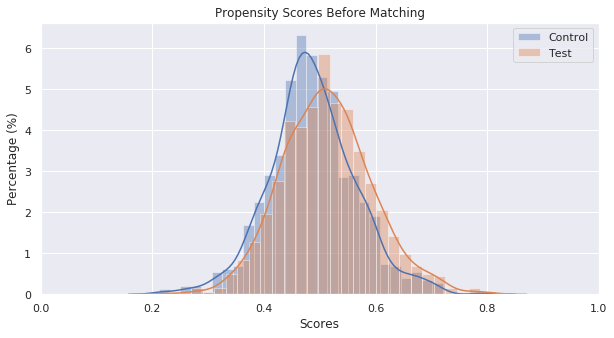

In [36]:
m.plot_scores()

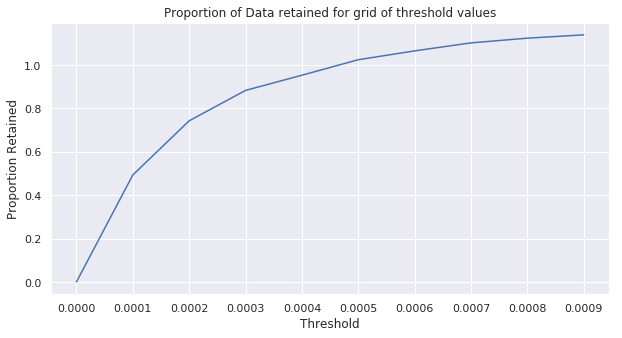

In [37]:
m.tune_threshold(method='random')

In [41]:
m.match(method="random", nmatches=1, threshold=0.00045)

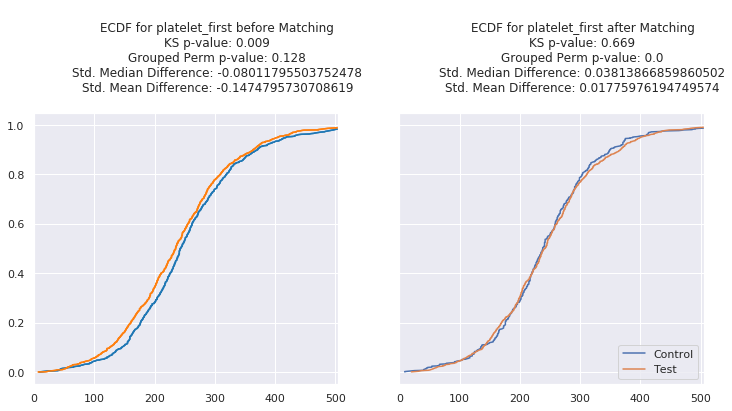

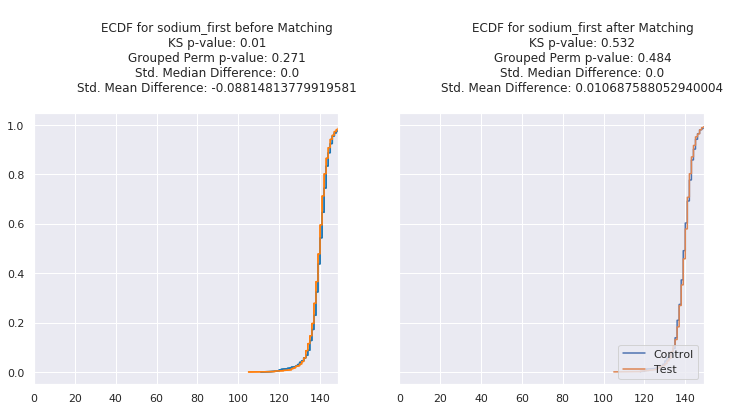

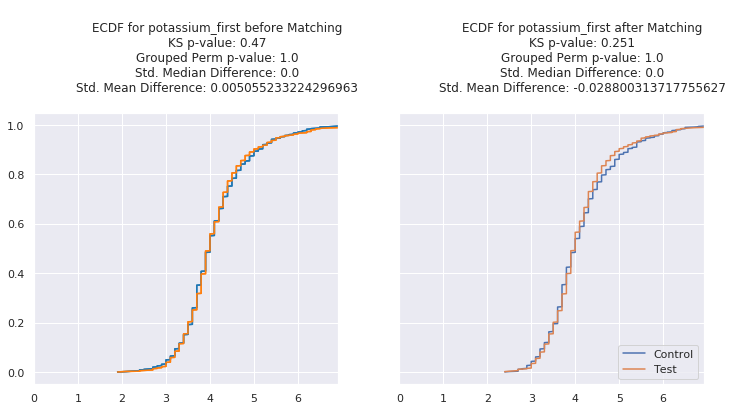

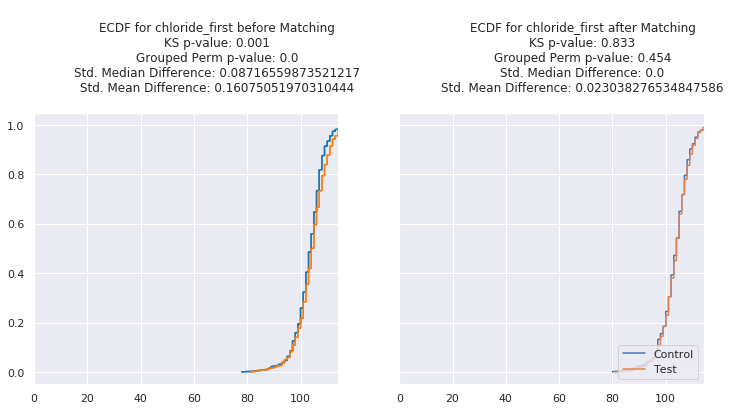

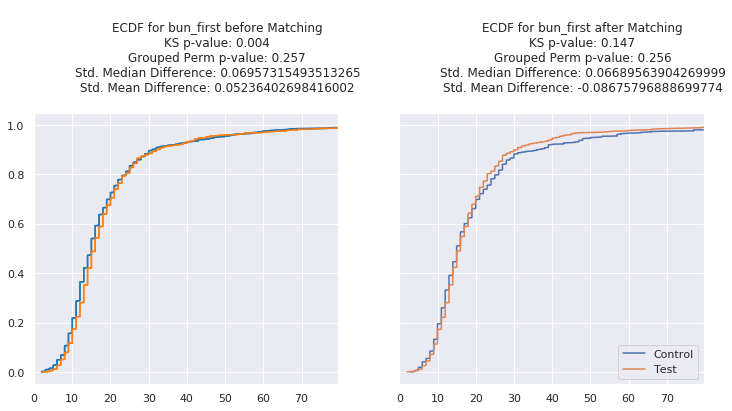

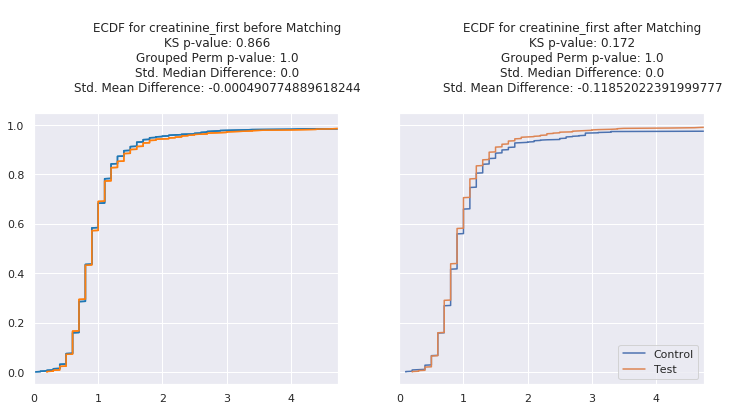

In [42]:
cc = m.compare_continuous(return_table=True)

In [48]:
m.matched_data.columns

Index(['aline_flg', 'platelet_first', 'sodium_first', 'potassium_first',
       'chloride_first', 'bun_first', 'creatinine_first', 'scores', 'match_id',
       'record_id'],
      dtype='object')

In [46]:
import seaborn as sns

Text(0.5, 0, 'Scores')

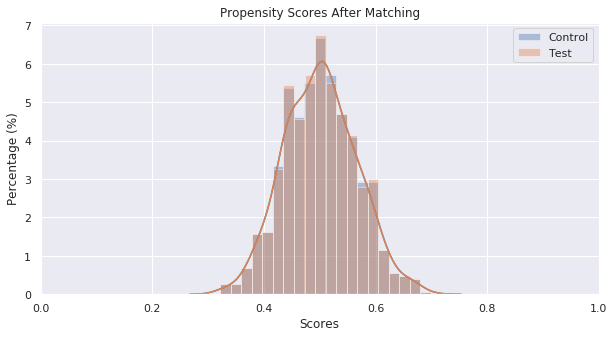

In [50]:
sns.distplot(m.matched_data[m.matched_data.aline_flg==0].scores, label='Control')
sns.distplot(m.matched_data[m.matched_data.aline_flg==1].scores, label='Test')
plt.legend(loc='upper right')
plt.xlim((0, 1))
plt.title("Propensity Scores After Matching")
plt.ylabel("Percentage (%)")
plt.xlabel("Scores")

### 案列2：利用XGBoost进行死亡率预测

在接下来的案例中，我们利用XGBoost建立对于ICU死亡率的预测模型，我们纳入的指标是所有的生化指标以及人口统计学因素，并与传统的临床评分进行效果对比。

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import xgboost as xgb

In [7]:
mortality_df = df[['sepsis_flg', 'age', 'gender_num', 'bmi', 'chf_flg', 'afib_flg',
                   'renal_flg', 'liver_flg', 'copd_flg', 'cad_flg', 'stroke_flg',
                   'mal_flg', 'resp_flg', 'map_1st', 'hr_1st', 'temp_1st', 'spo2_1st',
                   'abg_count', 'wbc_first', 'hgb_first', 'platelet_first', 'sodium_first',
                   'potassium_first', 'tco2_first', 'chloride_first', 'bun_first',
                   'creatinine_first', 'po2_first', 'pco2_first', 'icu_exp_flg']].copy()

将预测变量与结局变量进行分离：

In [8]:
x, y = mortality_df.iloc[:,:-1], mortality_df.iloc[:,-1]

将训练集与测试集按照**4:1**的比例进行划分：

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123)

构建XGBoost分类器：

In [13]:
alg = xgb.XGBClassifier(learning_rate=0.1, n_estimators=140, max_depth=5,
                        min_child_weight=3, gamma=0.2, subsample=0.6, colsample_bytree=1.0,
                        objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=27)

In [14]:
xgb_param = alg.get_xgb_params()

In [15]:
xgb_train = xgb.DMatrix(x_train.values, label=y_train.values)

In [16]:
cvresult = xgb.cv(xgb_param, xgb_train, num_boost_round=alg.get_params()['n_estimators'], nfold=5, 
                  early_stopping_rounds=50)

In [18]:
alg.set_params(n_estimators=cvresult.shape[0]);

In [20]:
alg.fit(x_train, y_train, eval_metric='auc')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1.0, gamma=0.2, learning_rate=0.1,
       max_delta_step=0, max_depth=5, min_child_weight=3, missing=None,
       n_estimators=27, n_jobs=1, nthread=4, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=27, silent=True, subsample=0.6)

In [52]:
predictions = alg.predict(x_test)
pred_proba = alg.predict_proba(x_test)[:, 1]
print("\n关于现在这个模型")
print("AUC 得分 (训练集): %f" % metrics.roc_auc_score(y_test, pred_proba))


关于现在这个模型
AUC 得分 (训练集): 0.817146


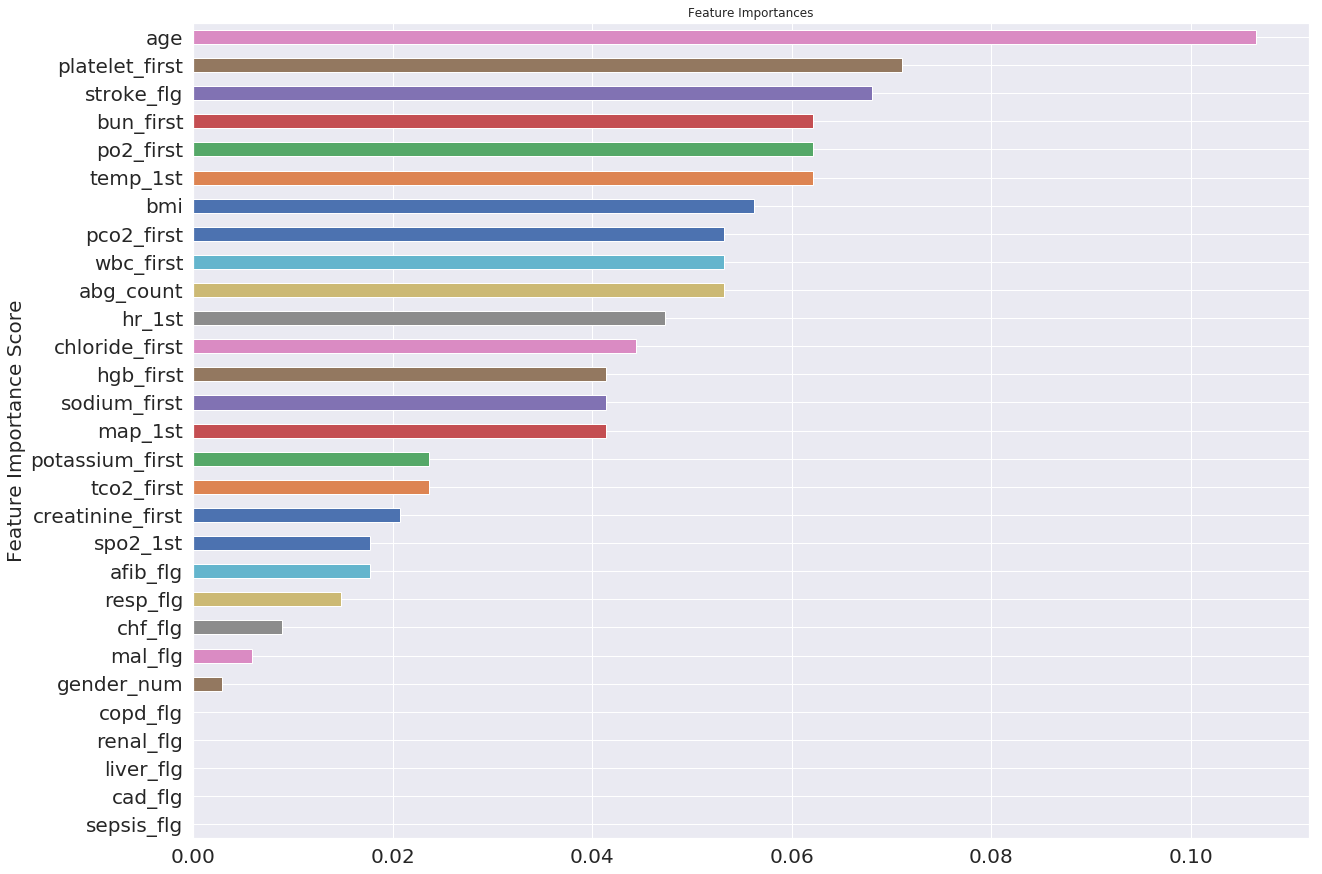

In [39]:
feat_imp = alg.feature_importances_
feat = x_train.columns.tolist()
# clf.best_estimator_.booster().get_fscore()
res_df = pd.DataFrame({'Features': feat, 'Importance': feat_imp}).sort_values(by='Importance', ascending=True)
res_df.plot('Features', 'Importance', kind='barh', title='Feature Importances', figsize=(20,15), legend=False, fontsize=20);
plt.ylabel('Feature Importance Score', fontsize=20);

In [45]:
sofa_df = df[['sofa_first', 'icu_exp_flg']].dropna()
sofa_x, sofa_y = sofa_df.iloc[:,:-1], sofa_df.iloc[:,-1]

In [46]:
sofa_x_train, sofa_x_test, sofa_y_train, sofa_y_test = train_test_split(sofa_x, sofa_y, test_size=0.2, random_state=123)

In [47]:
clf = LogisticRegression(C=1e5)
clf.fit(sofa_x_train, sofa_y_train)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [53]:
sofa_y_pred = clf.predict(sofa_x_test)
sofa_y_pred_proba = clf.predict_proba(sofa_x_test)[:, 1]
print("\n关于现在这个模型")
print("AUC 得分 (训练集): %f" % metrics.roc_auc_score(sofa_y_test, sofa_y_pred_proba))


关于现在这个模型
AUC 得分 (训练集): 0.704135


可以看出我们的机器学习模型比起传统的临床评分，有很大的优势。